In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from keras.layers import Activation, Reshape, Permute, multiply, MaxPooling2D, AveragePooling2D
import albumentations as albu
from albumentations import (HorizontalFlip, ShiftScaleRotate, GridDistortion)
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Load cifar10 data
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


In [0]:
train_y = keras.utils.to_categorical(train_y, 10)
test_y = keras.utils.to_categorical(test_y, 10)

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.25, random_state = 2019)

In [0]:
# Swish activation function : https://arxiv.org/abs/1710.05941
def _swish(x):
  return K.sigmoid(x)*x

#helper function for convolution -> batch_normalization-> activation
def _conv_bn_act(filters = 32, kernel_size = (3,3), strides = 1, activation = "relu"):

  def f(input_x):

    x = Conv2D(filters = filters, kernel_size = kernel_size, strides = (strides, strides), kernel_initializer="he_normal")(input_x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x

  return f

#helper function for fully-connected -> batch_normalization-> activation
def _fc_bn_act(units, activation = "relu"):

  def f(input_x):

    x = Dense(units = units, kernel_initializer="he_normal")(input_x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x
  return f

#Squeeze and excitation block in keras
def SEBlock(se_ratio = 16, activation = "relu", data_format = 'channels_last', ki = "he_normal"):
    '''
    se_ratio : ratio for reduce the filter number of first Dense layer(fc layer) in block
    activation : activation function that of first dense layer
    data_format : channel axis is at the first of dimension or the last
    ki : kernel initializer
    '''

    def f(input_x):

        channel_axis = -1 if data_format == 'channels_last' else 1
        input_channels = input_x._keras_shape[channel_axis]

        reduced_channels = input_channels // se_ratio

        #Squeeze operation
        x = GlobalAveragePooling2D()(input_x)
        x = Reshape(1,1,input_channels)(x) if data_format == 'channels_first' else x
        x = Dense(reduced_channels, kernel_initializer= ki)(x)
        x = Activation(activation)(x)
        #Excitation operation
        x = Dense(input_channels, kernel_initializer=ki, activation='sigmoid')(x)
        x = Permute(dims=(3,1,2))(x) if data_format == 'channels_first' else x
        x = multiply([input_x, x])

        return x

    return f


def CNN(input_shape = (32,32,3), output_units = 10, activation = _swish, SE_flag = False, data_format = 'channels_last'):

  input_layer = keras.layers.Input(shape = input_shape)

  x = _conv_bn_act(filters=32, activation = activation)(input_layer)
  x = SEBlock(se_ratio=1, activation = activation, data_format=data_format)(x) if SE_flag == True else x
  x = _conv_bn_act(filters=32, activation = activation)(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = _conv_bn_act(filters=64, activation = activation)(x)
  x = SEBlock(se_ratio=1, activation = activation, data_format=data_format)(x) if SE_flag == True else x
  x = _conv_bn_act(filters=64, activation = activation)(x)
  x = Dropout(0.25)(x)

  #Use GlobalAveragePooling2D to replace flatten
  x = GlobalAveragePooling2D()(x)
  x = Reshape(1,1,x._keras_shape[1])(x) if data_format == 'channels_first' else x
    
  x = _fc_bn_act(units=256, activation = activation)(x)
  x = Dropout(0.25)(x)
  x = _fc_bn_act(units=128, activation = activation)(x)
  
  output_layer = Dense(units = output_units, activation="softmax", kernel_initializer="he_normal")(x)

  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model

In [0]:
batch_size = 128
lr = 1e-3
epochs = 20
optimizer = keras.optimizers.Adam(lr=lr)
loss = "categorical_crossentropy"
metric = ['accuracy']

steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_test) // batch_size

In [0]:
def input_generator(x,y,aug,batch_size):

  x_len = len(x)
  batch_x, batch_y = [],[]
  while True:

    batch_indices = np.random.choice(x_len, size = batch_size)
    
    for idx in batch_indices:
      batch_y.append(y[idx])
      batch_x.append(aug(image = x[idx])['image']/255.0)

    batch_x, batch_y = np.stack(batch_x), np.stack(batch_y)
    yield batch_x, batch_y
    batch_x, batch_y = [],[]
  
aug_for_train = albu.Compose([HorizontalFlip(p=0.5),
                              ShiftScaleRotate(shift_limit=0.1,scale_limit=0.25,rotate_limit=20,p=0.5),
                              GridDistortion(p=0.5)])
aug_for_valid = albu.Compose([])

train_gen = input_generator(x_train, y_train, aug_for_train, batch_size)
valid_gen = input_generator(x_test, y_test, aug_for_valid, batch_size)

In [0]:
def display_training_result(history):

  plt.figure(figsize=(16,12))

  plt.subplot(2,1,1)
  plt.plot(history.history['loss'], label = 'train_loss', color = 'g')
  plt.plot(history.history['val_loss'], label = 'valid_loss', color = 'r')
  plt.title('training/validation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(history.history['acc'], label = 'train_acc', color = 'g')
  plt.plot(history.history['val_acc'], label = 'valid_acc', color = 'r')
  plt.title('training/validation accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()

  plt.show()

In [10]:
# Build the regular Convolution neural network
regular_cnn = CNN()
regular_cnn.compile(loss = loss, metrics = metric, optimizer = optimizer)
regular_cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 32)        0   

In [9]:
regular_cnn_history = regular_cnn.fit_generator(generator=train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                                                validation_data=valid_gen, validation_steps=validation_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
292/292 [==============================] - 27s 93ms/step - loss: 1.6107 - acc: 0.4077 - val_loss: 1.6095 - val_acc: 0.4409
Epoch 2/20
292/292 [==============================] - 21s 74ms/step - loss: 1.3361 - acc: 0.5208 - val_loss: 1.2428 - val_acc: 0.5457
Epoch 3/20
292/292 [==============================] - 22s 75ms/step - loss: 1.2060 - acc: 0.5709 - val_loss: 1.2593 - val_acc: 0.5641
Epoch 4/20
292/292 [==============================] - 21s 73ms/step - loss: 1.1291 - acc: 0.5968 - val_loss: 1.2508 - val_acc: 0.5697
Epoch 5/20
292/292 [==============================] - 21s 73ms/step - loss: 1.0819 - acc: 0.6157 - val_loss: 0.9878 - val_acc: 0.6450
Epoch 6/20
292/292 [==============================] - 21s 72ms/step - loss: 1.0224 - acc: 0.6372 - val_loss: 0.9627 - val_acc: 0.6595
Epoch 7/20
292/292 [==============================] - 21s 72ms/step - loss: 0.9848 - acc: 0.6503 - val

In [11]:
# Build the convolution neural network with SE block in it
SE_cnn = CNN(SE_flag = True)
SE_cnn.compile(loss = loss, metrics = metric, optimizer = optimizer)
SE_cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 30, 30, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 30, 30, 32)   128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 30, 30, 32)   0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

In [16]:
SE_cnn_history = SE_cnn.fit_generator(generator=train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                                                validation_data=valid_gen, validation_steps=validation_steps)

Epoch 1/20
292/292 [==============================] - 26s 89ms/step - loss: 1.5830 - acc: 0.4190 - val_loss: 1.5278 - val_acc: 0.4465
Epoch 2/20
292/292 [==============================] - 23s 79ms/step - loss: 1.2923 - acc: 0.5316 - val_loss: 1.1565 - val_acc: 0.5824
Epoch 3/20
292/292 [==============================] - 22s 76ms/step - loss: 1.1684 - acc: 0.5790 - val_loss: 1.0259 - val_acc: 0.6248
Epoch 4/20
292/292 [==============================] - 23s 78ms/step - loss: 1.0780 - acc: 0.6151 - val_loss: 0.9771 - val_acc: 0.6442
Epoch 5/20
292/292 [==============================] - 22s 76ms/step - loss: 1.0339 - acc: 0.6294 - val_loss: 0.9465 - val_acc: 0.6664
Epoch 6/20
292/292 [==============================] - 23s 77ms/step - loss: 0.9914 - acc: 0.6480 - val_loss: 0.9410 - val_acc: 0.6617
Epoch 7/20
292/292 [==============================] - 22s 76ms/step - loss: 0.9476 - acc: 0.6646 - val_loss: 0.8868 - val_acc: 0.6867
Epoch 8/20
292/292 [==============================] - 23s 77ms

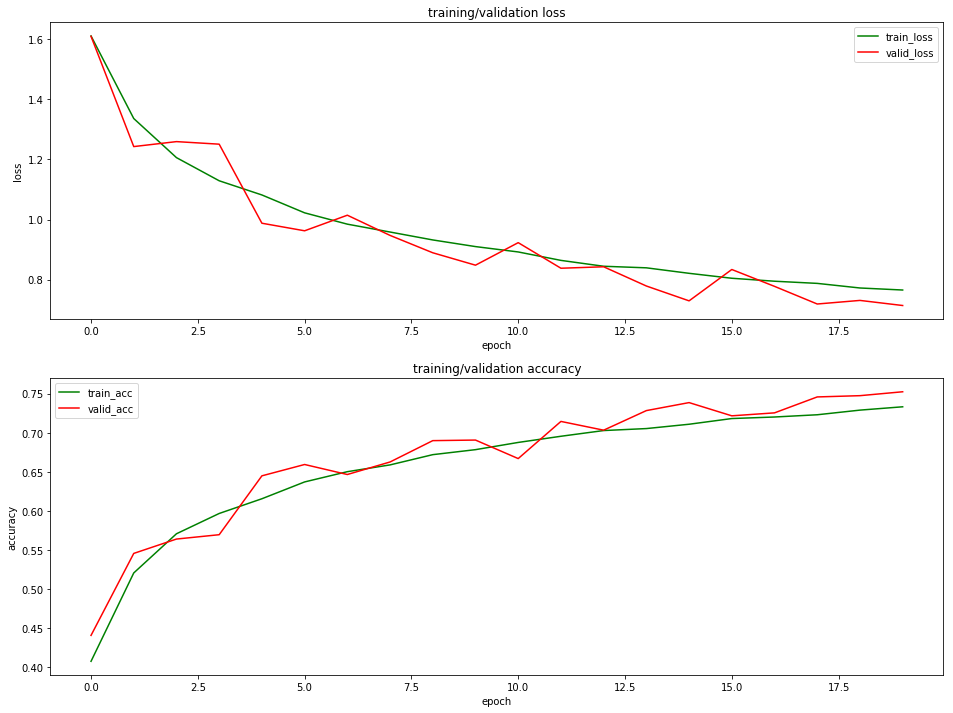

In [22]:
display_training_result(regular_cnn_history)

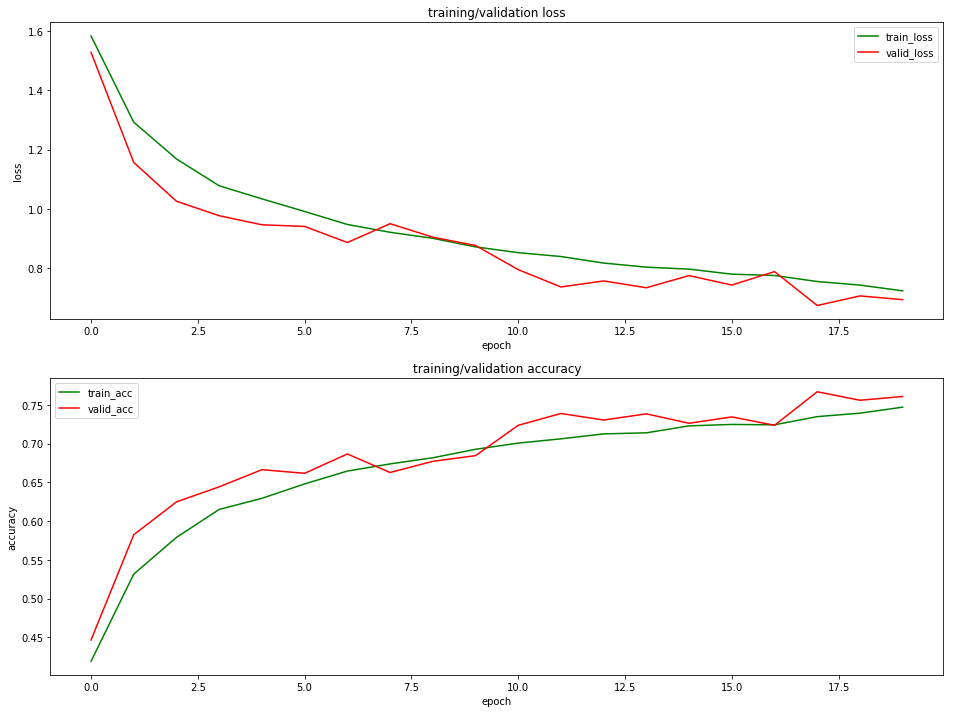

In [23]:
display_training_result(SE_cnn_history)

In [18]:
regular_cnn_scores = regular_cnn.evaluate(x=x_test/255.0, y=y_test)
SE_cnn_scores = SE_cnn.evaluate(x=x_test/255.0, y=y_test)

12500/12500 [==============================] - 2s 181us/step


In [20]:
print(f' Regular CNN :  loss {regular_cnn_scores[0]}, accuracy {regular_cnn_scores[1]}')
print(f' SE CNN : loss {SE_cnn_scores[0]}, accruacy {SE_cnn_scores[1]}')

 Regular CNN :  loss 0.717884089794159, accuracy 0.7539200000190734
 SE CNN : loss 0.6834373204803467, accruacy 0.7627999999809265
